In [212]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from lockstar_rpi.BackendSettings import BackendSettings
from numpy import uint32
from numpy import int32

In [213]:
    def calculate_prescaler_counter(sampling_rate):
        """Calculate prescaler and counter for a given sampling_rate. The MC realizes a sampling rate by scaling down 
        the internal clock_frequency (BackendSettings.mc_sampling_clock_rate) with the prescaler and then counting up to
        <counter> --> sampling_rate = internal_clock_rate / prescaler / counter"""
        rate = BackendSettings.mc_sampling_clock_rate / sampling_rate
        possible_counters = np.flip(np.arange(ceil(rate/BackendSettings.mc_max_counter), BackendSettings.mc_max_counter))
        possible_prescalers = rate/possible_counters
        best_prescaler = int(possible_prescalers[np.abs(possible_prescalers - possible_prescalers.astype(int)).argmin()])
        best_counter = int(rate/best_prescaler)
        return best_prescaler - 1  , best_counter - 1

In [215]:
calculate_prescaler_counter(550000)

(0, 499)

In [37]:
bit="16"
TIM_BASE_CLOCK=275000000
TARGET_F = 850000
error=1
max_results=-1
DUTY=50.0

In [38]:
TARGET_ARR_MAX = { "8": 2**8-1, "16": 2**16-1, "32": 2**32-1 }
TARGET_PSC_MAX= { "16": 2**16-1 }
TARGET_PSC=0
TARGET_ARR=0



TARGET_UPDATE_F_MAX = TIM_BASE_CLOCK / ((TARGET_PSC + 1)*(TARGET_ARR+1))
TARGET_UPDATE_F_MIN = TIM_BASE_CLOCK / ((TARGET_PSC_MAX["16"] + 1)*(TARGET_ARR_MAX[bit]+1))
print("TARGET_UPDATE_F_MAX", TARGET_UPDATE_F_MAX)
print("TARGET_UPDATE_F_MIN", TARGET_UPDATE_F_MIN)

TARGET_UPDATE_F_MAX 275000000.0
TARGET_UPDATE_F_MIN 0.06402842700481415


In [39]:
results = []

def search_arr_psc():
    right = TIM_BASE_CLOCK / TARGET_F
    # right=int(right)
    print("(arr+1)*(psc+1) = TIM_BASE_CLOCK / TARGET_F")
    print("(arr+1)*(psc+1) =", TIM_BASE_CLOCK, "/", TARGET_F)
    print("(arr+1)*(psc+1) =",right)
    if TIM_BASE_CLOCK % TARGET_F != 0:
        print("\nSOLUTION WITHOUT ERROR NOT POSSIBLE - TIM_BASE_CLOCK / TARGET_F is not integer")
        if error == 0:
            print("You must use an --error= value >0 for this frequency!")
            quit()
    print( "Calculate...")
    for psc in range(0,TARGET_PSC_MAX["16"]+1):
        x = (TIM_BASE_CLOCK / (TARGET_F * (psc+1))) -1 
        if TIM_BASE_CLOCK  % (psc+1) == 0 and x <= TARGET_ARR_MAX[bit]:
            for arr in range(0,TARGET_ARR_MAX[bit]+1):
                left = (arr+1)*(psc+1) 
                pererror = abs((1- (TARGET_F / (TIM_BASE_CLOCK/left)))*100)
                if pererror <= error:
                    freq = TIM_BASE_CLOCK/left
                    d = int(arr/(100.0/DUTY))
                    results.append({"psc":psc,"arr":arr,"left":left,"freq":freq,"pererror":pererror,"delta":abs(freq-TARGET_F),"duty":d})
def secondlist(x):
    s = x
    ms = x*(10**3)
    us = x*(10**6)
    ns = x*(10**9)
    ps = x*(10**12)
    fs = x*(10**15)
    return {"s":s, "ms":ms, "µs":us, "ns":ns, "ps":ps, "fs":fs}


In [40]:
search_arr_psc()

if error != 0:
    result_sorted = sorted(results, key = lambda i: (i['pererror']))
else:
    result_sorted = sorted(results, key = lambda i: (i['psc']))

j=0
for i in result_sorted:
    if j == max_results:
        quit()
    print("PSC:",i["psc"],"ARR:",i["arr"]," => FREQ:",i["freq"],"[Hz]","ERROR:",i["pererror"],"[%] - CRRx[",DUTY,"%]:",i["duty"])
    j+=1
print (j,"Results. Reduce with --max=")

(arr+1)*(psc+1) = TIM_BASE_CLOCK / TARGET_F
(arr+1)*(psc+1) = 275000000 / 850000
(arr+1)*(psc+1) = 323.52941176470586

SOLUTION WITHOUT ERROR NOT POSSIBLE - TIM_BASE_CLOCK / TARGET_F is not integer
Calculate...
PSC: 0 ARR: 323  => FREQ: 848765.4320987654 [Hz] ERROR: 0.1454545454545597 [%] - CRRx[ 50.0 %]: 161
PSC: 1 ARR: 161  => FREQ: 848765.4320987654 [Hz] ERROR: 0.1454545454545597 [%] - CRRx[ 50.0 %]: 80
PSC: 3 ARR: 80  => FREQ: 848765.4320987654 [Hz] ERROR: 0.1454545454545597 [%] - CRRx[ 50.0 %]: 40
PSC: 0 ARR: 322  => FREQ: 851393.1888544891 [Hz] ERROR: 0.1636363636363547 [%] - CRRx[ 50.0 %]: 161
PSC: 0 ARR: 324  => FREQ: 846153.8461538461 [Hz] ERROR: 0.454545454545463 [%] - CRRx[ 50.0 %]: 162
PSC: 4 ARR: 64  => FREQ: 846153.8461538461 [Hz] ERROR: 0.454545454545463 [%] - CRRx[ 50.0 %]: 32
PSC: 24 ARR: 12  => FREQ: 846153.8461538461 [Hz] ERROR: 0.454545454545463 [%] - CRRx[ 50.0 %]: 6
PSC: 0 ARR: 321  => FREQ: 854037.2670807453 [Hz] ERROR: 0.4727272727272691 [%] - CRRx[ 50.0 %]: 160

In [191]:
num_samples = 10000
amplitude = np.float32(1.0)
frequency = np.float32(1.0)
x_values = np.float32(np.linspace(1, -1, num_samples+1))

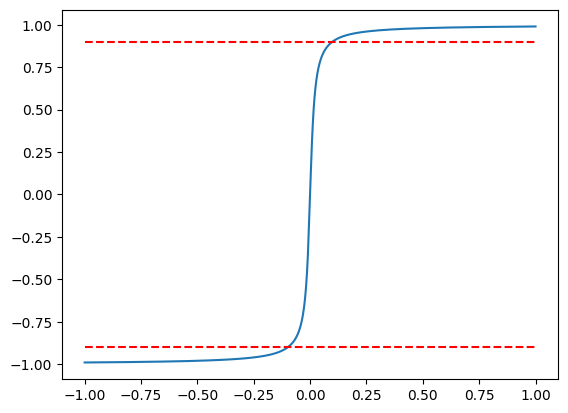

In [192]:
y_values = np.float32(np.arctan(x_values*64))*2/np.pi
plt.plot(x_values, y_values)
plt.hlines(0.9, -1, 1, colors='r', linestyles='dashed')
plt.hlines(-0.9, -1, 1, colors='r', linestyles='dashed')

In [193]:
flat_one = len(y_values[y_values < -0.9])
flat_two = len(y_values[y_values > 0.9])
print(flat_one, flat_two)

4507 4507


In [194]:
y_values = y_values/y_values[0]

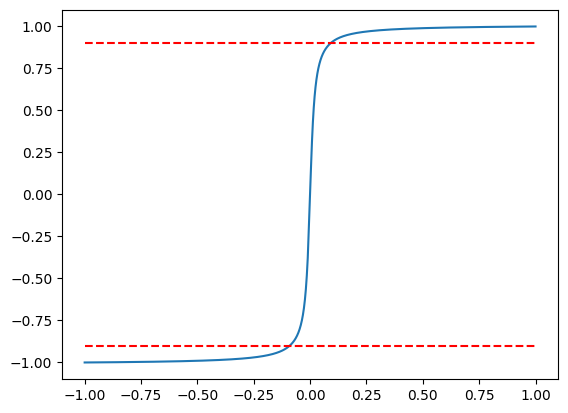

In [195]:
plt.plot(x_values, y_values)
plt.hlines(0.9, -1, 1, colors='r', linestyles='dashed')
plt.hlines(-0.9, -1, 1, colors='r', linestyles='dashed')

In [196]:
flat_one = len(y_values[y_values < -0.9])
flat_two = len(y_values[y_values > 0.9])
print(flat_one, flat_two)

4548 4548


In [62]:
def to_q31(x):
    return int(x * 2**31)

In [63]:
num_samples = 1000
ramp_begin = -0.1
ramp_end = 0.1

start_value = to_q31(ramp_begin)
end_value = to_q31(ramp_end)
step_size = (ramp_end - ramp_begin)/num_samples
step_size = to_q31(step_size)
scaling_factor = 6
scaling = np.abs((2**scaling_factor)/(np.arctan(ramp_begin*(2**scaling_factor))/np.pi))
amplitude = 4
total_scaling = scaling * amplitude
offset = 4
print(scaling, total_scaling, start_value, step_size)

142.0129882634997 568.0519530539988 -214748364 429496


In [154]:
def to_float(value: uint32, scaling: float, offset) -> float:
    mask = 0xFFFFFFFF
    sign_mask = 0x80000000
    if (value & sign_mask) == 0:
        val = int32(value)
    else:
        val = int32(-((value ^ mask) + 1))
    print(val)
    return ((val) / (1 << 31)) * scaling + offset

In [204]:
def ramp_gen(sampling_freq, flat_scale, ramp_time, amplitude, offset, inverse=False):
    cordic_scaling_factor = 6

    num_samples = int(ramp_time * sampling_freq)
    ramp_begin = -flat_scale
    ramp_end = flat_scale
    inverse = False
    start_value = to_q31(ramp_begin)
    end_value = to_q31(ramp_end)
    step_size = (ramp_end - ramp_begin)/num_samples
    step_size = to_q31(step_size)

    scaling = (2**cordic_scaling_factor)/(np.arctan(ramp_begin*(2**cordic_scaling_factor))/np.pi)
    scaling = -scaling if inverse else scaling
    total_scaling = scaling * amplitude
    print(total_scaling, offset, num_samples, start_value, step_size)
    return total_scaling, offset, num_samples, start_value, step_size

In [206]:
ramp_gen(500000, 0.1, 0.01, 4, 4)

-568.0519530539988 4 5000 -214748364 85899


In [207]:
def sin_gen(sample_freq, wave_freq, amplitude, offset):
    num_samples = int(sample_freq/wave_freq)
    start_value = 0
    step_size = 0xFFFFFFFF/num_samples
    return amplitude, offset, num_samples, start_value, step_size

In [211]:
sin_gen(500000, 100, 4, 0)

(4, 0, 5000, 0, 858993.459)